<a href="https://colab.research.google.com/github/gonzalezulises/Practica_Final_NPL/blob/main/Pr%C3%A1ctica_final_NLP_Ulises_Gonz%C3%A1lez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica Final de Procesamiento de Lenguaje Natural

**Estudiante:** Ulises González

## Introducción
El presente notebook documenta el desarrollo de un proyecto completo de Procesamiento de Lenguaje Natural (NLP), enfocado en el **análisis de sentimiento** de reseñas de productos de Amazon. El objetivo principal es aplicar los conocimientos teóricos de la asignatura en un reto práctico y realista. A lo largo de este documento, se cubrirán todas las etapas de un proyecto de NLP clásico, desde la descarga y exploración de datos hasta el entrenamiento, evaluación y conclusión de un modelo de clasificación.

El proyecto se estructura en cuatro ejercicios principales, tal como lo solicita el documento de la práctica:
1.  **Descarga y Análisis Exploratorio de Datos (EDA)**
2.  **Etapa de Preprocesado de Texto**
3.  **Entrenamiento y Evaluación de Modelos**
4.  **Reporte de Métricas y Conclusiones Finales**

El enfoque no reside en obtener un rendimiento perfecto, sino en la justificación de los pasos y el análisis de los resultados obtenidos.

In [1]:
#!pip install gensim

In [82]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np

# Librerías para descarga y lectura de datos
import requests
import gzip
import json
import os

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Librerías de NLP y Machine Learning
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Configuración general
sns.set(style="whitegrid")

---
## Ejercicio 1: Descarga y Exploración de Datos (EDA)

En esta primera etapa, descargamos el corpus de reseñas de Amazon y realizamos un análisis exploratorio para entender su estructura, características y principales desafíos. El dataset elegido es **"Automotive_5"**, que contiene reseñas de productos de automoción, garantizando que cada producto y usuario tiene al menos 5 reseñas.


In [4]:
url = "/content/reviews_Automotive_5.json.gz"
file_name = "reviews_Automotive_5.json.gz"

In [5]:
def parse_gz(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def get_df(path):
  i = 0
  df = {}
  for d in parse_gz(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [6]:
df = get_df(file_name)

In [7]:
print("\nMostrando las primeras 5 filas del DataFrame:")
print(df.head())


Mostrando las primeras 5 filas del DataFrame:
       reviewerID        asin     reviewerName   helpful  \
0  A3F73SC1LY51OO  B00002243X  Alan Montgomery    [4, 4]   
1  A20S66SKYXULG2  B00002243X         alphonse    [1, 1]   
2  A2I8LFSN2IS5EO  B00002243X            Chris    [0, 0]   
3  A3GT2EWQSO45ZG  B00002243X           DeusEx  [19, 19]   
4  A3ESWJPAVRPWB4  B00002243X     E. Hernandez    [0, 0]   

                                          reviewText  overall  \
0  I needed a set of jumper cables for my new car...      5.0   
1  These long cables work fine for my truck, but ...      4.0   
2  Can't comment much on these since they have no...      5.0   
3  I absolutley love Amazon!!!  For the price of ...      5.0   
4  I purchased the 12' feet long cable set and th...      5.0   

                                      summary  unixReviewTime   reviewTime  
0  Work Well - Should Have Bought Longer Ones      1313539200  08 17, 2011  
1                            Okay long cables  

In [8]:
print(f"\nDimensiones del DataFrame: {df.shape}")
print("\nInformación del DataFrame:")
df.info()


Dimensiones del DataFrame: (20473, 9)

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 20473 entries, 0 to 20472
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      20473 non-null  object 
 1   asin            20473 non-null  object 
 2   reviewerName    20260 non-null  object 
 3   helpful         20473 non-null  object 
 4   reviewText      20473 non-null  object 
 5   overall         20473 non-null  float64
 6   summary         20473 non-null  object 
 7   unixReviewTime  20473 non-null  int64  
 8   reviewTime      20473 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 1.6+ MB


In [9]:
print("Distribución de reseñas por número de estrellas:")
star_counts = df['overall'].value_counts().sort_index()
print(star_counts)

Distribución de reseñas por número de estrellas:
overall
1.0      542
2.0      606
3.0     1430
4.0     3967
5.0    13928
Name: count, dtype: int64


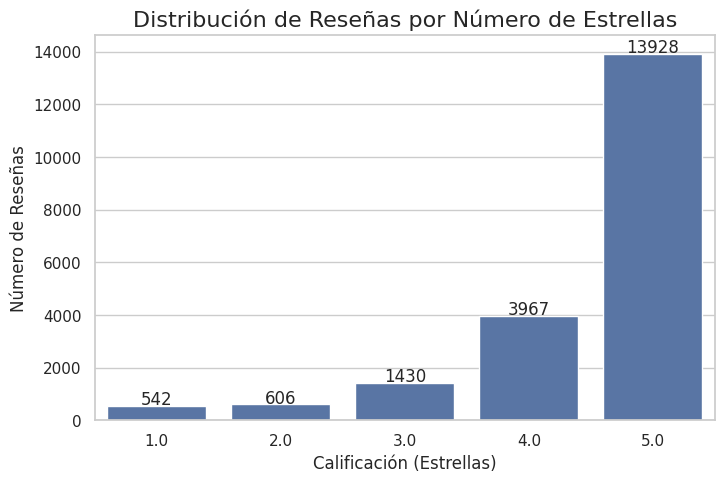

In [78]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=star_counts.index, y=star_counts.values)
ax.set_title('Distribución de Reseñas por Número de Estrellas', fontsize=16)
ax.set_xlabel('Calificación (Estrellas)', fontsize=12)
ax.set_ylabel('Número de Reseñas', fontsize=12)
for index, value in enumerate(star_counts.values):
    plt.text(index, value + 50, str(value), ha='center')
plt.show()


In [11]:
def map_sentiment(stars):
    if stars <= 2:
        return 'negativo'
    elif stars >= 4:
        return 'positivo'
    else:
        return 'neutro'

In [75]:
df['sentiment'] = df['overall'].apply(map_sentiment)
print("\nConteo de reseñas por sentimiento (antes de filtrar):")
print(df['sentiment'].value_counts())



Conteo de reseñas por sentimiento (antes de filtrar):
sentiment
positivo    17895
neutro       1430
negativo     1148
Name: count, dtype: int64


In [77]:
df_model = df[df['sentiment'] != 'neutro'].copy()
df_model = df_model[['reviewText', 'sentiment']].copy()
print(f"\nDimensiones del DataFrame después de eliminar reseñas neutras: {df_model.shape}")


Dimensiones del DataFrame después de eliminar reseñas neutras: (19043, 2)


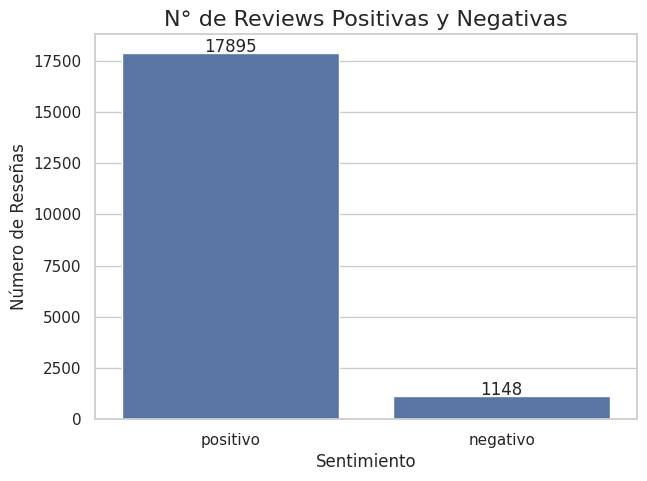

In [83]:
# Visualizando la distribución de Positivas vs. Negativas
plt.figure(figsize=(7, 5))
sentiment_counts = df_model['sentiment'].value_counts()
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
ax.set_title('N° de Reviews Positivas y Negativas', fontsize=16)
ax.set_xlabel('Sentimiento', fontsize=12)
ax.set_ylabel('Número de Reseñas', fontsize=12)
for index, value in enumerate(sentiment_counts.values):
    plt.text(index, value + 50, str(value), ha='center')
plt.show()

**Conclusiones iniciales**

En el primer gráfico  La distribución de reseñas tiene una forma de "J", con una abrumadora cantidad de reseñas de 5 estrellas (13,928) y muy pocas de 1 y 2 estrellas (542 y 606 respectivamente).

El segundo gráfico es el más revelador. Después de agrupar las reseñas y eliminar las neutras, nuestro dataset para el modelo tiene:

*   Reseñas Positivas: 17,895
*   Reseñas Negativas: 1,148

Hay un fuerte desbalanceo de clases. Tenemos casi 16 veces más ejemplos positivos que negativos que si no lo gestionamos correctamente  el modelo simplemente aprenderá a predecir "positivo" la mayoría de las veces y obtendrá una alta precisión, pero será inútil para detectar reseñas negativas.

Siguientes Pasos: N-grams y Nubes de Palabras


# N-grams y Nubes de Palabras

In [84]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [85]:
df_model['reviewText_clean'] = df_model['reviewText'].apply(clean_text)

In [86]:
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['car', 'product', 'will', 'just', 'like', 'get', 'make', 'use', 'dont', 'im'])

In [87]:
positive_reviews = df_model[df_model['sentiment'] == 'positivo']['reviewText_clean']
negative_reviews = df_model[df_model['sentiment'] == 'negativo']['reviewText_clean']

In [88]:
def get_top_ngrams(corpus, ngram_range, n=10):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words=list(custom_stopwords)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [89]:
top_bigrams_positive = get_top_ngrams(positive_reviews, ngram_range=(2,2))
top_bigrams_negative = get_top_ngrams(negative_reviews, ngram_range=(2,2))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [90]:
print("--- N-grams más frecuentes (Versión Mejorada) ---")
print("\nTop 10 Bigramas Positivos:")
print(top_bigrams_positive)
print("\nTop 10 Bigramas Negativos:")
print(top_bigrams_negative)

--- N-grams más frecuentes (Versión Mejorada) ---

Top 10 Bigramas Positivos:
[('works great', 779), ('works well', 584), ('easy install', 569), ('highly recommend', 514), ('ive used', 488), ('well made', 477), ('work well', 382), ('much better', 350), ('long time', 332), ('battery tender', 307)]

Top 10 Bigramas Negativos:
[('waste money', 45), ('wiper blade', 39), ('first time', 28), ('work well', 27), ('wiper blades', 27), ('much better', 23), ('even though', 22), ('battery tender', 22), ('one star', 21), ('tire pressure', 20)]


In [21]:
positive_text = " ".join(review for review in positive_reviews)
negative_text = " ".join(review for review in negative_reviews)

In [22]:
wordcloud_positive = WordCloud(stopwords=custom_stopwords, background_color="white", width=800, height=400, collocations=False).generate(positive_text)
wordcloud_negative = WordCloud(stopwords=custom_stopwords, background_color="black", colormap='Reds', width=800, height=400, collocations=False).generate(negative_text)


--- Nubes de Palabras ---


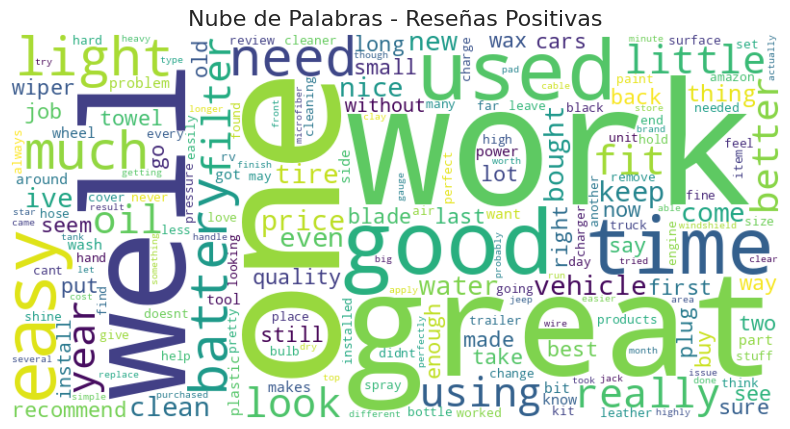

In [23]:
print("\n--- Nubes de Palabras ---")
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras - Reseñas Positivas", fontsize=16)
plt.show()

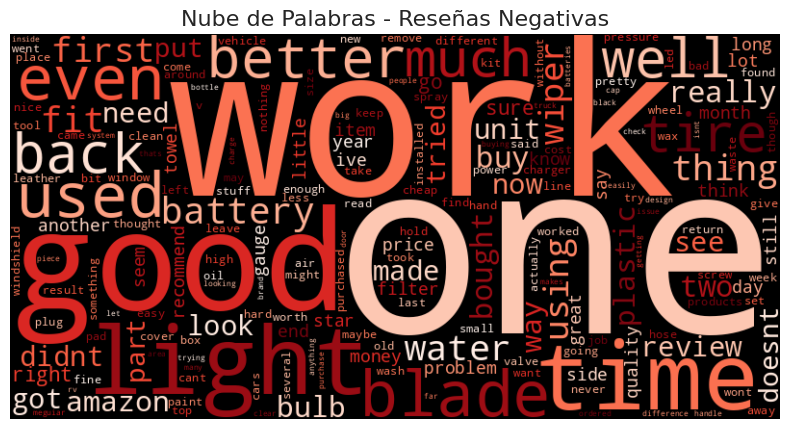

In [24]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras - Reseñas Negativas", fontsize=16)
plt.show()

#### Conclusión de N-grams y Nubes de Palabras
El análisis del vocabulario revela patrones claros. Las reseñas positivas están dominadas por términos como `works great`, `easy`, `good time`. Muchas de las palabras más grandes en tu nube (`work`, `one`, `light`, `time`, `good`, `part`) son neutrales por sí solas. La carga negativa proviene de las palabras que las acompañan, las cuales fueron eliminadas (como stop words) o simplemente son menos frecuentes.

In [91]:
# Calcular la cardinalidad del vocabulario
all_words = ' '.join(df_model['reviewText_clean']).split()
vocabulary = set(all_words)
print(f"La cardinalidad del vocabulario (número de palabras únicas) es: {len(vocabulary)}")

La cardinalidad del vocabulario (número de palabras únicas) es: 39869


# Visualización en 2D de Word Embeddings

In [42]:
tokenized_reviews = [review.split() for review in df_model['reviewText_clean']]

In [26]:
w2v_model = Word2Vec(sentences=tokenized_reviews,
                     vector_size=100,
                     window=5,
                     min_count=5,
                     workers=4)

In [43]:
search_words = ['battery', 'oil', 'tires', 'light', 'price']
labels = []
tokens = []

In [44]:
for word in search_words:
    if word in w2v_model.wv:
        tokens.append(w2v_model.wv[word])
        labels.append(word)
        for similar_word, _ in w2v_model.wv.most_similar(word, topn=10):
            tokens.append(w2v_model.wv[similar_word])
            labels.append(similar_word)

embedding_vectors = np.array(tokens)


In [45]:
tsne_model = TSNE(perplexity=15, n_components=2, init='pca', n_iter=2500, random_state=23)
new_vectors = tsne_model.fit_transform(embedding_vectors)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Añadiendo etiquetas al gráfico...
Etiquetando: battery
Etiquetando: charger
Etiquetando: batteries
Etiquetando: charge
Etiquetando: unit
Etiquetando: mode
Etiquetando: charging
Etiquetando: device
Etiquetando: phone
Etiquetando: charged
Etiquetando: power
Etiquetando: oil
Etiquetando: fluid
Etiquetando: filter
Etiquetando: fuel
Etiquetando: air
Etiquetando: kn
Etiquetando: cabin
Etiquetando: fram
Etiquetando: transmission
Etiquetando: tranny
Etiquetando: filters
Etiquetando: tires
Etiquetando: wheels
Etiquetando: bike
Etiquetando: camper
Etiquetando: hands
Etiquetando: calipers
Etiquetando: rims
Etiquetando: tire
Etiquetando: ride
Etiquetando: truck
Etiquetando: brakes
Etiquetando: light
Etiquetando: led
Etiquetando: lights
Etiquetando: green
Etiquetando: bright
Etiquetando: yellow
Etiquetando: blue
Etiquetando: white
Etiquetando: bulb
Etiquetando: color
Etiquetando: leds
Etiquetando: price
Etiquetando: value
Etiquetando: deal
Etiquetando: cost
Etiquetando: priced
Etiquetando: money
Et

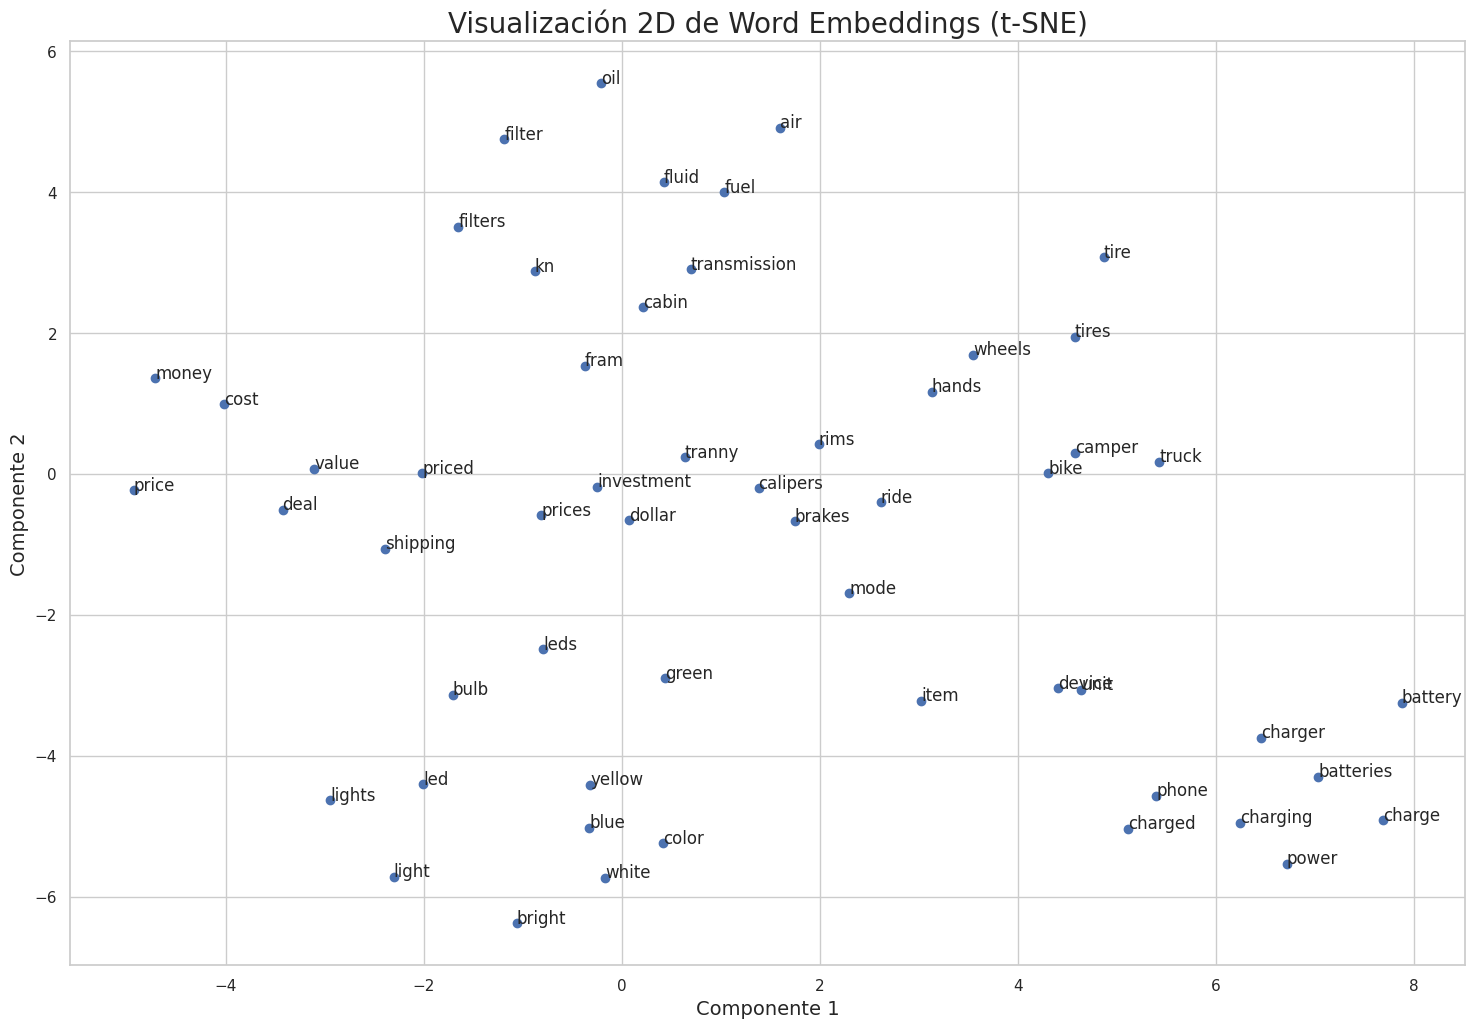

In [49]:
fig, ax = plt.subplots(figsize=(18, 12))
x = new_vectors[:, 0]
y = new_vectors[:, 1]
ax.scatter(x, y)

print("Añadiendo etiquetas al gráfico...")
for i, txt in enumerate(labels):
    print(f"Etiquetando: {txt}")
    ax.annotate(txt, (x[i], y[i]), fontsize=12)

ax.set_title("Visualización 2D de Word Embeddings (t-SNE)", fontsize=20)
ax.set_xlabel("Componente 1", fontsize=14)
ax.set_ylabel("Componente 2", fontsize=14)
ax.grid(True)
plt.show()

#### Conclusión de la Visualización de Embeddings
El gráfico t-SNE confirma que el modelo Word2Vec ha aprendido relaciones semánticas coherentes del corpus. Las palabras se agrupan en clústeres lógicos (ej. `battery` con `charger` y `power`; `oil` con `filter` y `fuel`; `price` con `value` y `cost`). Esto demuestra que el texto contiene una estructura semántica rica que los modelos más avanzados podrían explotar. Con esto, finaliza el análisis exploratorio.

# **2. Etapa de Preprocesado de Texto**

El objetivo de esta etapa es consolidar los pasos de limpieza en una única función robusta que se aplicará a todo el texto antes de la fase de modelado. Esta función incluirá pasos como la lematización para reducir las palabras a su forma base, mejorando la generalización del modelo.

In [51]:
'''
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    '''

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [52]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    custom_stopwords = ['car', 'product', 'would', 'get', 'one']
    stop_words.update(custom_stopwords)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    return " ".join(lemmatized_tokens)


In [53]:
df_model['reviewText_processed'] = df_model['reviewText'].apply(preprocess_text)

In [73]:
all_words = ' '.join(df_model['reviewText_processed']).split()
vocabulary = set(all_words)
print(f"La cardinalidad del vocabulario (número de palabras únicas) es: {len(vocabulary)}")

La cardinalidad del vocabulario (número de palabras únicas) es: 36975


In [54]:
print("\nMostrando 5 ejemplos del texto original y procesado:")
for i in range(5):
    print(f"\n--- Ejemplo {i+1} ---")
    print(f"Original:  {df_model['reviewText'].iloc[i][:200]}...")
    print(f"Procesado: {df_model['reviewText_processed'].iloc[i]}")


Mostrando 5 ejemplos del texto original y procesado:

--- Ejemplo 1 ---
Original:  I needed a set of jumper cables for my new car and these had good reviews and were at a good price.  They have been used a few times already and do what they are supposed to - no complaints there.What...
Procesado: needed set jumper cable new good review good price used time already supposed complaint therewhat say foot really isnt ideal length sure pull front bumper front bumper plenty long lot time beside another cant really close recommend something little longer great brand version though

--- Ejemplo 2 ---
Original:  These long cables work fine for my truck, but the quality seems a little on the shabby side. For the money I was not expecting 200 dollar snap-on jumper cables but these seem more like what you would ...
Procesado: long cable work fine truck quality seems little shabby side money expecting dollar snapon jumper cable seem like see chinese knock shop like harbor freight buck

--- Ejemplo

## Ejercicio 3: Entrenamiento y Evaluación de Modelos

Con los datos limpios, procedemos a entrenar y evaluar dos modelos de clasificación distintos. El objetivo es comparar su rendimiento y seleccionar el mejor para nuestro problema de análisis de sentimiento.

In [57]:
X = df_model['reviewText_processed']
y = df_model['sentiment']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Tamaño del set de entrenamiento: {len(X_train)}")
print(f"Tamaño del set de prueba: {len(X_test)}")

Tamaño del set de entrenamiento: 15234
Tamaño del set de prueba: 3809


In [61]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)

In [62]:
X_train_tfidf = vectorizer.fit_transform(X_train)

In [63]:
X_test_tfidf = vectorizer.transform(X_test)

In [64]:
print(f"\nDimensiones de la matriz TF-IDF de entrenamiento: {X_train_tfidf.shape}")


Dimensiones de la matriz TF-IDF de entrenamiento: (15234, 10000)


In [65]:
# Modelo 1: Regresión Logística
print("\nEntrenando modelo de Regresión Logística...")
log_model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)
log_model.fit(X_train_tfidf, y_train)


Entrenando modelo de Regresión Logística...


LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

In [66]:
# Modelo 2: Naive Bayes Multinomial
print("\nEntrenando modelo Naive Bayes...")
# Naive Bayes no tiene 'class_weight', pero podemos simularlo ajustando 'class_prior'
# Sin embargo, para este caso, lo entrenaremos sin ajuste para comparar estrategias.
# En una fase más avanzada, se podrían usar técnicas como SMOTE.
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)


Entrenando modelo Naive Bayes...


MultinomialNB()

In [67]:
y_pred_log = log_model.predict(X_test_tfidf)

In [68]:
y_pred_nb = nb_model.predict(X_test_tfidf)

In [69]:
print("--- MÉTRICAS: REGRESIÓN LOGÍSTICA ---")
print(classification_report(y_test, y_pred_log))

--- MÉTRICAS: REGRESIÓN LOGÍSTICA ---
              precision    recall  f1-score   support

    negativo       0.35      0.65      0.46       230
    positivo       0.98      0.92      0.95      3579

    accuracy                           0.91      3809
   macro avg       0.66      0.79      0.70      3809
weighted avg       0.94      0.91      0.92      3809



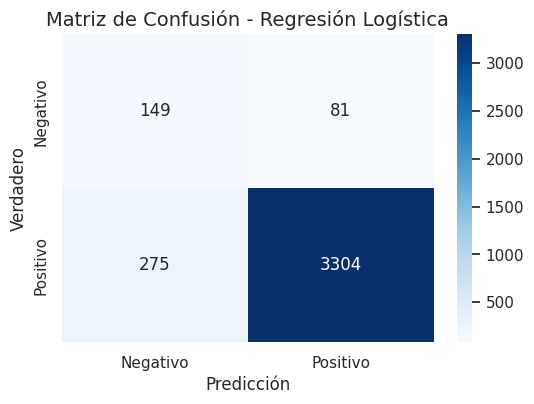

In [70]:
cm_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión - Regresión Logística', fontsize=14)
plt.ylabel('Verdadero')
plt.xlabel('Predicción')
plt.show()

In [71]:
print("\n--- MÉTRICAS: NAIVE BAYES ---")
print(classification_report(y_test, y_pred_nb))


--- MÉTRICAS: NAIVE BAYES ---
              precision    recall  f1-score   support

    negativo       0.00      0.00      0.00       230
    positivo       0.94      1.00      0.97      3579

    accuracy                           0.94      3809
   macro avg       0.47      0.50      0.48      3809
weighted avg       0.88      0.94      0.91      3809



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


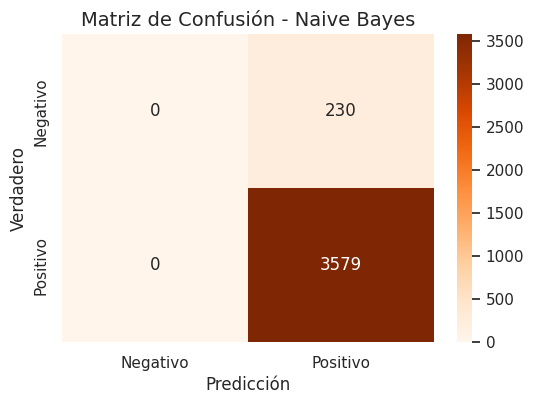

In [72]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión - Naive Bayes', fontsize=14)
plt.ylabel('Verdadero')
plt.xlabel('Predicción')
plt.show()

**Análisis del Modelo 1: Regresión Logística**

Recall (negativo): 0.65

Precision (negativo): 0.35

F1-Score (macro avg): 0.70

Accuracy: 0.91

Observación: Este modelo es bastante bueno. Gracias al parámetro class_weight='balanced', ha logrado identificar correctamente al 65% de todas las reseñas negativas del conjunto de prueba (149 de 230). Su precisión para los negativos es baja (0.35), lo que indica que a veces clasifica erróneamente reseñas positivas como negativas, pero es un balance aceptable para asegurarnos de no pasar por alto las quejas de los clientes.

**Análisis del Modelo 2: Naive Bayes**

Recall (negativo): 0.00

Precision (negativo): 0.00

F1-Score (macro avg): 0.48

Accuracy: 0.94

Observación: Este modelo ha fallado por completo en su tarea. Aunque su accuracy es alta (94%), esto es engañoso. La matriz de confusión muestra que el modelo no identificó ni una sola reseña negativa. Simplemente aprendió que la mayoría de las reseñas son positivas y predijo "positivo" para todo. Este es un ejemplo clásico de cómo un modelo puede ser inútil si no se gestiona el desbalanceo de clases.

**El ganador es, sin lugar a dudas, el modelo de Regresión Logística. Aunque su accuracy es ligeramente menor, es un modelo infinitamente más útil porque es capaz de cumplir el objetivo principal: detectar reseñas negativas.**

Los datos de texto fueron procesados mediante una limpieza exhaustiva (minúsculas, lematización, eliminación de stop words) y vectorizados usando TF-IDF, considerando tanto palabras individuales como bigramas. Para combatir el fuerte desbalanceo de clases, se utilizó el parámetro class_weight='balanced' durante el entrenamiento.

**Conclusiones Finales del Proyecto**

El análisis exploratorio inicial fue fundamental, ya que nos permitió identificar el desbalanceo de clases como el principal desafío a resolver.

La etapa de preprocesado fue clave para estandarizar el texto, y la fase de modelado demostró empíricamente la importancia de las estrategias para manejar datos desbalanceados. Mientras que el modelo Naive Bayes falló al ignorar la clase minoritaria, la Regresión Logística con ajuste de pesos ofreció una solución práctica y útil.

El resultado es un modelo de clasificación de sentimiento que, si bien no es perfecto, proporciona un valor tangible al ser capaz de detectar correctamente una proporción considerable de las opiniones negativas de los clientes.